# Data Science - Laboratorio 6
## Minería de Texto: Análisis de Sentimientos
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -
## Ejercicio 2 - Online Product Reviews

## Librerias

NOTA Importante tener el Token de la API en el folder:

**C:\Users\<Windows-username>\.kaggle\kaggle.json**

Para una guia mas detallada o si tiene otro sistema dirigase a: https://www.kaggle.com/docs/api#getting-started-installation-&-authentication 

Asimismo puede visitar la documentacion oficial de la API: https://github.com/Kaggle/kaggle-api/tree/main/docs#api-credentials

In [1]:
# Kaggle API
import kaggle
from kaggle.rest import ApiException

# Operaciones con archivos
import os
import zipfile

# Operaciones con datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from wordcloud import WordCloud

# Procesamiento de lengauje natural
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Modelado y evaluación
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Utilidades
from collections import Counter

## Carga de Dataset

### Descargar el archivo con Kaggle

Puede omitir esta celda si decide descargar los archivos manualmente desde https://www.kaggle.com/datasets/datafiniti/grammar-and-online-product-reviews

In [2]:
# Autenticación con Kaggle API
kaggle.api.authenticate()

# Definir dataset y directorio de descarga
dataset_name = 'datafiniti/grammar-and-online-product-reviews'
target_path = 'data'
file_name = 'GrammarandProductReviews.csv'

# Verificar si existen archivos descargados previamente
if not os.path.exists(f"{target_path}/ej2-data.csv"):
    # Descargar archivo desde Kaggle
    try:
        kaggle.api.dataset_download_file(dataset=dataset_name,
                                         file_name=file_name,
                                         path=target_path,
                                         quiet=False,
                                         force=False)
        
        print(f"EXITO: {file_name} descargado en '{target_path}'")

    except ApiException as e:
        print(f"ERROR al llamar KaggleApi -> dataset_download_file \n\t{e}")
else:
    print("AVISO: Se encontraron archivos descargados previamente")
    print(f"\tSi desea descargar nuevamente el archivo, elimine '{target_path}/{file_name}.zip'")

Dataset URL: https://www.kaggle.com/datasets/datafiniti/grammar-and-online-product-reviews


100%|██████████| 8.95M/8.95M [00:00<00:00, 16.9MB/s]


EXITO: GrammarandProductReviews.csv descargado en 'data'


### Descomprimir el Zip

Puede omitir esta celda si ya tiene los archivos descomprimidos

In [3]:
# Verificar si ya se descomprimieron los archivos .zip previamente
if  os.path.exists(f"{target_path}/ej2-data.csv"):
    print("AVISO: Se encontraron archivos descargados previamente")
    print("\tOmitiendo descompresión de archivos .zip")

# Descomprimir archivos .zip
else:
    try:
        # Verificar si se descargó un archivo .zip y descomprimirlo
        if os.path.exists(f"{target_path}/{file_name}.zip"):
            # Descomprimir archivo .zip
            with zipfile.ZipFile(f'{target_path}/{file_name}.zip', 'r') as zip_ref:
                zip_ref.extractall(target_path)
            
            # Renombrar archivos
            os.rename(f'{target_path}/{file_name}', f'{target_path}/ej2-data.csv')

            # Eliminar archivo .zip
            os.remove(f'{target_path}/{file_name}.zip')
            print(f"EXITO: Archivo .zip {file_name} descomprimido en '{target_path}' como 'ej2-data.csv'")
        else:
            raise Exception(f"No se encontró archivo .zip en '{target_path}'")

    except Exception as e:
        print(f"ERROR al descomprimir archivo .zip \n\t{e}")

EXITO: Archivo .zip GrammarandProductReviews.csv descomprimido en 'data' como 'ej2-data.csv'


### Generar dataframes

In [4]:
# Cargar archivos en DataFrames
reviews_df = pd.read_csv('data/ej2-data.csv')

## Comprensión Inicial

### Información General del Dataset

In [5]:
def get_DF_info(df):
    """
    Función que genera un dataframe con información sobre las columnas de un dataframe dado.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        
    Returns:
        None
    """
    # Crear un dataframe con la información de las columnas    
    info = pd.DataFrame({
        'Nombre Columna': df.columns,
        'Tipo de Dato': df.dtypes,
        'Valores Nulos (%)': (df.isnull().sum() * 100 / df.shape[0]).round(2),
        'Valores Únicos': df.nunique(),
        'Valores Duplicados': df.duplicated().sum()
    }).reset_index(drop=True)

    # Mostrar la informacion
    print(f"\nEl dataframe tiene {df.shape[0]} filas (registros) y {df.shape[1]} columnas (variables)\n")
    display(info)

In [6]:
print(f"Informacion del dataset: ej2-data.csv")
get_DF_info(df=reviews_df)

Informacion del dataset: ej2-data.csv

El dataframe tiene 71044 filas (registros) y 25 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos,Valores Duplicados
0,id,object,0.00,600,0
1,brand,object,0.00,392,0
2,categories,object,0.00,581,0
3,dateAdded,object,0.00,598,0
4,dateUpdated,object,0.00,354,0
5,ean,object,45.01,473,0
6,keys,object,0.00,600,0
7,manufacturer,object,0.20,463,0
8,manufacturerNumber,object,0.29,583,0
9,name,object,0.00,600,0


El dataset tiene una combinación de campos categóricos y numéricos, con reseñas de productos (texto, rating, recomendaciones), información de productos (marca, categoría, fabricante), y detalles del usuario (nombre, ubicación). La mayoría de los datos son de tipo `object`, lo cual requerirá un preprocesamiento significativo.

Algunas columnas presentan un alto porcentaje de valores nulos, como `reviews.userProvince` (**99.37%**) y `reviews.userCity` (**92.39%**), lo que sugiere que no se puede confiar en estas variables para análisis profundos. Además, la columna `ean` tiene **45.01%** de valores nulos, lo que indica que esta variable también podría ser problemática para el análisis. 

Varias columnas contienen texto, como `reviews.text`, `reviews.title`, y `name`. Para las reseñas, será necesario realizar tareas de limpieza (remover caracteres especiales, normalización del texto, etc.), así como aplicar técnicas de procesamiento del lenguaje natural (NLP) para análisis de sentimientos y frecuencias de palabras.

Las columnas como `reviews.rating`, `reviews.didPurchase`, y `reviews.doRecommend` pueden ser útiles para evaluar la calidad percibida de los productos. Sin embargo, `reviews.didPurchase` tiene más del **50%** de valores nulos, lo que puede limitar su uso.

Las columnas `reviews.username` y `reviews.id` permitirán analizar qué usuarios realizan más reseñas y cómo varían sus opiniones. Además, campos como `brand`, `manufacturer`, y `upc` facilitarán la identificación de los productos y marcas más y menos valorados.

### Visualizar Dataframe

In [7]:
reviews_df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


### Identificación de Variables

- `id`: Identificador único del producto.
- `brand`: Marca del producto.
- `categories`: Categorías a las que pertenece el producto.
- `dateAdded`: Fecha en la que se añadió el producto al sistema.
- `dateUpdated`: Fecha en la que se actualizó por última vez el producto.
- `ean`: European Article Number, un identificador único de producto, pero con muchos valores nulos.
- `keys`: Palabras clave relacionadas con el producto.
- `manufacturer`: Fabricante del producto.
- `manufacturerNumber`: Número de referencia del fabricante para identificar el producto.
- `name`: Nombre del producto.
- `reviews.date`: Fecha en la que se escribió la reseña.
- `reviews.dateAdded`: Fecha en la que se añadió la reseña al sistema.
- `reviews.dateSeen`: Fecha en la que la reseña fue vista por última vez.
- `reviews.didPurchase`: Indicador (booleano) de si el usuario compró el producto antes de dejar la reseña (puede tener valores nulos).
- `reviews.doRecommend`: Indicador (booleano) de si el usuario recomienda el producto (puede tener valores nulos).
- `reviews.id`: Identificador único de la reseña.
- `reviews.numHelpful`: Número de veces que la reseña fue marcada como útil.
- `reviews.rating`: Calificación del producto (normalmente en una escala de 1 a 5).
- `reviews.sourceURLs`: URL desde donde proviene la reseña.
- `reviews.text`: Texto de la reseña.
- `reviews.title`: Título de la reseña.
- `reviews.userCity`: Ciudad del usuario que dejó la reseña (muchos valores nulos).
- `reviews.userProvince`: Provincia del usuario que dejó la reseña (muchos valores nulos).
- `reviews.username`: Nombre de usuario del autor de la reseña.
- `upc`: Código Universal de Producto (Universal Product Code), un identificador único de producto.

## Preprocesamiento y Limpieza

### Valores Nulos

#### Verificación valores nulos

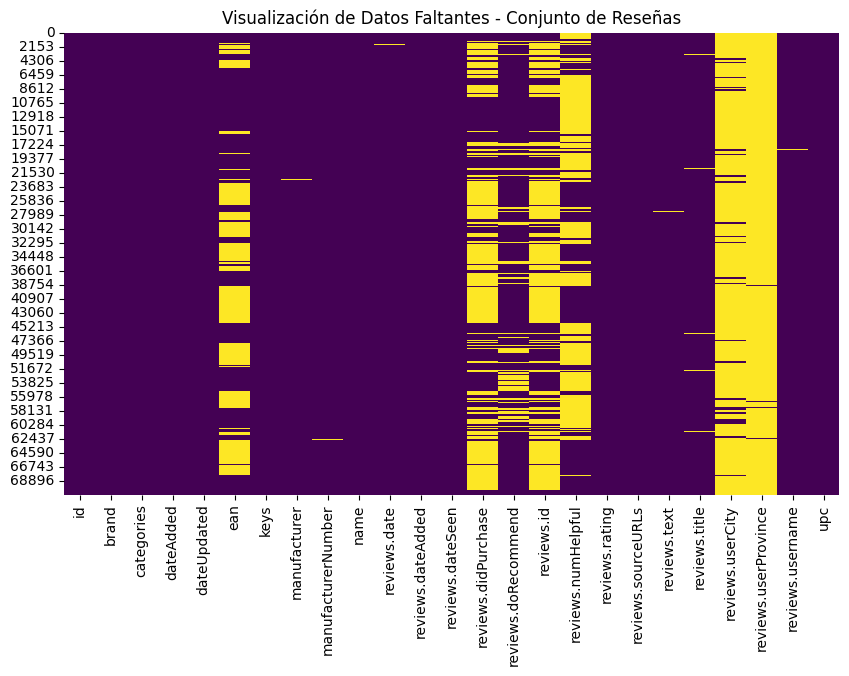

In [8]:
# Visualización de los datos faltantes en el conjunto de entrenamiento
plt.figure(figsize=(10, 6))
sns.heatmap(reviews_df.isnull(), cbar=False, cmap="viridis")
plt.title("Visualización de Datos Faltantes - Conjunto de Reseñas")
plt.show()

Este gráfico visualiza los datos faltantes en el conjunto de reseñas. Los valores en amarillo representan los datos nulos, mientras que los valores en morado representan los datos presentes.

**Columnas con muchos valores nulos:**
- `ean`: Una gran cantidad de valores nulos, lo cual coincide con el 45.01% reportado.
- `reviews.didPurchase` y `reviews.id`: Más del 50% de los datos están faltantes, lo que limita su utilidad para el análisis.
- `reviews.userCity` y `reviews.userProvince`: Ambas columnas tienen una alta proporción de valores nulos, especialmente `reviews.userProvince`, que está casi completamente vacía.

**Otras columnas con valores faltantes:**
- `manufacturer`, `manufacturerNumber`, y `reviews.numHelpful`: También tienen una cantidad significativa de valores nulos, pero no tan alta como las anteriores.
  
**Columnas sin valores nulos:**
- Algunas columnas, como id, brand, categories, dateAdded, reviews.rating, y reviews.sourceURLs, no muestran valores faltantes, lo que indica que son completas y confiables para el análisis.

#### Análisis de Impacto de nulos

In [9]:
# Total de registros iniciales
initial_count = reviews_df.shape[0]

# Escenario 1: Eliminar todos los registros con valores nulos
dropna_all = reviews_df.dropna()
dropna_all_count = dropna_all.shape[0]

# Escenario 2: Eliminar los registros con nulos en columnas con más del 1% de nulos
# Identificamos las columnas con más del 1% de valores nulos
columns_gt_1pct = reviews_df.columns[reviews_df.isnull().mean() > 0.01]
dropna_gt_1pct = reviews_df.dropna(subset=columns_gt_1pct)
dropna_gt_1pct_count = dropna_gt_1pct.shape[0]

# Escenario 3: Eliminar los registros con nulos en columnas con menos del 1% de nulos
# Identificamos las columnas con menos del 1% de valores nulos
columns_lt_1pct = reviews_df.columns[reviews_df.isnull().mean() <= 0.01]
dropna_lt_1pct = reviews_df.dropna(subset=columns_lt_1pct)
dropna_lt_1pct_count = dropna_lt_1pct.shape[0]

# Cálculo de porcentajes conservados
dropna_all_pct = (dropna_all_count / initial_count) * 100
dropna_gt_1pct_pct = (dropna_gt_1pct_count / initial_count) * 100
dropna_lt_1pct_pct = (dropna_lt_1pct_count / initial_count) * 100

# Resultados del análisis de impacto
impact_analysis = pd.DataFrame({
    'Escenario': ['Original', 'Eliminando nulos de columnas (>1%)', 'Eliminando nulos de columnas (<1%)', 'Eliminando todos los nulos'],
    'Conteo': [initial_count, dropna_gt_1pct_count, dropna_lt_1pct_count, dropna_all_count],
    'Porcentaje conservado (%)': [100, dropna_gt_1pct_pct, dropna_lt_1pct_pct, dropna_all_pct]
})

display(impact_analysis)

,Escenario,Conteo,Porcentaje conservado (%)
0,Original,71044,100.00000
1,Eliminando nulos de columnas (>1%),0,0.00000
2,Eliminando nulos de columnas (<1%),70053,98.60509
3,Eliminando todos los nulos,0,0.00000


Estos resultados muestran que eliminar los registros nulos tiene un impacto significativo en el tamaño del conjunto de datos:

- Al eliminar los registros con valores nulos en las columnas que tienen más del **1%** de datos faltantes, se conservan **0 registros**. Esto indica que las columnas con grandes porcentajes de nulos, como `reviews.didPurchase`, `reviews.doRecommend`, y `reviews.id`, están afectando enormemente la integridad del dataset. La eliminación total no es viable en este caso ya que resultaría en la pérdida completa del dataset.

- Por otro lado, al eliminar los registros con valores nulos únicamente en las columnas que tienen menos del **1%** de nulos, se conserva el **98.61%** de los registros originales. Este impacto es marginal, lo que sugiere que eliminar estos registros es una opción aceptable y no afectaría significativamente el análisis. Por tanto, es preferible perder ese pequeño porcentaje de registros en lugar de imputar datos en estas columnas.

- Finalmente, si se decidiera eliminar todos los registros con valores nulos, se perdería el **100%** del dataset, lo cual no es viable para continuar con el análisis.

En conclusión, para mantener la mayor parte del dataset, lo más recomendable es eliminar los registros nulos de las columnas con menos del 1% de datos faltantes, y eliminar todas las columnas con mas del **1%** de los datos faltantes para evitar perdidas drasticas de datos.

#### Manejo de Nulos

In [10]:
# Eliminar variables con más del 1% de valores nulos
reviews_df.drop(columns=columns_gt_1pct, inplace=True)

# Eliminar registros con valores nulos en columnas con menos del 1% de valores nulos
reviews_df.dropna(subset=columns_lt_1pct, inplace=True)

# Verificar si se eliminaron todos los registros con valores nulos
print("Datos falantes en el conjunto de datos:")
print(reviews_df.isnull().sum())

Datos falantes en el conjunto de datos:
id                    0
brand                 0
categories            0
dateAdded             0
dateUpdated           0
keys                  0
manufacturer          0
manufacturerNumber    0
name                  0
reviews.date          0
reviews.dateAdded     0
reviews.dateSeen      0
reviews.rating        0
reviews.sourceURLs    0
reviews.text          0
reviews.title         0
reviews.username      0
upc                   0
dtype: int64


Con el estado actual de los datos sin valores faltantes, y las preguntas por responder basadas en las reseñas, la limpieza y procesamiento de texto se debe aplicar a las columnas que contienen texto relevante para el análisis de reseñas.

Las columnas más relevantes para aplicar este proceso son:

- `reviews.text`: Esta es la columna principal de interés, ya que contiene el texto completo de la reseña que vamos a analizar. Aquí es donde la limpieza del texto, la normalización, la eliminación de palabras vacías y la lematización tendrán el mayor impacto.

- `reviews.title`: Aunque el título es más breve, también es un resumen de la opinión del usuario. Aplicar las mismas técnicas de limpieza en esta columna puede ayudar a mejorar la precisión del análisis de sentimiento y la clasificación de productos.

- Otras columnas como `brand`, `name`, `manufacturer`, y `categories` contienen información útil para la identificación del producto, pero no son texto libre que requiera un procesamiento semántico profundo, por lo que no es necesario aplicar el proceso de limpieza a estas columnas.

### Limpieza y Normalización de Texto

**Paso 1: Limpieza del Texto**
- Eliminar URLs: Los URLs no aportan valor en el análisis de reseñas, por lo que se eliminarán.
- Eliminar caracteres especiales: Se eliminarán caracteres especiales como `#`, `@`, dígitos, y cualquier otro símbolo que no sea relevante para el contenido semántico del texto.
- Eliminar emoticones: Al igual que los caracteres especiales, los emoticones no son útiles en este contexto, por lo que también se eliminan.

**Paso 2: Normalización del Texto**
- Convertir a minúsculas: Para evitar tratar palabras como diferentes si solo varían en el uso de mayúsculas o minúsculas, todas las palabras se convertirán a minúsculas.

**Paso 3: Eliminación de Palabras Vacías (Stopwords)**
- Eliminar palabras comunes: Se eliminan las palabras vacías (stopwords) del idioma inglés, como `the`, `and`, `is`, etc., ya que no aportan valor en la clasificación de sentimientos o en el análisis de reseñas.

**Paso 4: Lematización**
- Lematización: A diferencia del stemming, que simplemente recorta palabras, la lematización transforma cada palabra a su forma raíz adecuada según el contexto. Esto permite reducir el vocabulario manteniendo la semántica.

In [11]:
# Descargar stopwords y otros recursos de nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Definir las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Función para limpiar y lematizar texto
def clean_and_lemmatize_text(text):
    # Eliminar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Eliminar caracteres especiales, números, y emoticones
    text = re.sub(r'\@\w+|\#|\d+|[^\w\s]', '', text)
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Aplicar lematización
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

# Aplicar la función de limpieza y lematización a las columnas relevantes
reviews_df['clean_reviews_text'] = reviews_df['reviews.text'].apply(clean_and_lemmatize_text)
reviews_df['clean_reviews_title'] = reviews_df['reviews.title'].apply(clean_and_lemmatize_text)

# Mostrar las primeras filas del dataset después de la limpieza
reviews_df[['reviews.text', 'clean_reviews_text', 'reviews.title', 'clean_reviews_title']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,reviews.text,clean_reviews_text,reviews.title,clean_reviews_title
0,i love this album. it's very good. more to the...,love album good hip hop side current pop sound...,Just Awesome,awesome
1,Good flavor. This review was collected as part...,good flavor review collected part promotion,Good,good
2,Good flavor.,good flavor,Good,good
3,I read through the reviews on here before look...,read review looking buying one couple lubrican...,Disappointed,disappointed
4,My husband bought this gel for us. The gel cau...,husband bought gel u gel caused irritation fel...,Irritation,irritation


Al aplicar estos pasos de limpieza y normalización, se obtiene un conjunto de datos de texto más conciso y manejable, que conserva únicamente la información esencial de las reseñas. Este enfoque es crucial para mejorar tanto la eficacia como la precisión de los análisis subsecuentes, como la clasificación de sentimientos, la identificación de patrones recurrentes en las opiniones, y la evaluación de la calidad de los productos según la retroalimentación de los usuarios.

El proceso de depuración permite transformar textos que, en su estado original, podían ser complejos y estar llenos de ruido, en textos más simplificados y estructurados. Al eliminar elementos irrelevantes y estandarizar el contenido, se facilita considerablemente el análisis. Esto, a su vez, permite extraer insights más precisos y significativos, lo que resulta esencial para generar modelos de análisis más robustos y tomar decisiones fundamentadas basadas en las opiniones de los usuarios. Además, este enfoque contribuye a reducir la dimensionalidad del conjunto de datos, optimizando el rendimiento de los modelos y mejorando la interpretación de los resultados.

## Análisis de Frecuencias de Palabras

### Conteo de palabras

Dado que no existe una variable "target" clara en este análisis, lo que se ha hecho es evaluar las frecuencias de palabras en las columnas correspondientes a los títulos de las reseñas `reviews.title` y el texto completo de las reseñas `reviews.text`. Este enfoque permite obtener una visión más general de los temas y términos recurrentes en las reseñas, lo cual es útil para entender las opiniones de los usuarios y los aspectos más mencionados en los productos evaluados.

In [12]:
def plot_bars_and_wordcloud(common_terms, term_wordcloud, title_bar, title_wordcloud):
    """
    Función que genera un gráfico de barras y una nube de palabras.

    Args:
        common_terms (list): Lista de tuplas con las palabras más comunes y su frecuencia.
        term_wordcloud (WordCloud): Objeto WordCloud con la nube de palabras.
        title_bar (str): Título del gráfico de barras.
        title_wordcloud (str): Título de la nube de palabras.

    Returns:
        None
    """
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    # Gráfico de barras
    terms, counts = zip(*common_terms)
    
    # Crear un colormap
    cmap = colormaps['viridis']
    
    # Generar colores en base al colormap
    colors = cmap(np.linspace(0, 1, len(terms)))
    
    axs[0].barh(terms, counts, color=colors)
    axs[0].set_xlabel('Frequency')
    axs[0].set_title(title_bar)
    axs[0].invert_yaxis()

    # Nube de palabras
    axs[1].imshow(term_wordcloud, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title(title_wordcloud)

    plt.show()

In [13]:
# Crear una lista con todas las palabras de reviews.text
all_words_text = ' '.join(reviews_df['clean_reviews_text']).split()
all_words_title = ' '.join(reviews_df['clean_reviews_title']).split()

# Contar la frecuencia de las palabras
word_freq_text = Counter(all_words_text)
word_freq_title = Counter(all_words_title)

# Obtener las 20 palabras más comunes
common_terms_text = word_freq_text.most_common(20)
common_terms_title = word_freq_title.most_common(20)

# Generar nubes de palabras
wordcloud_text = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_text)
wordcloud_title = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_title)

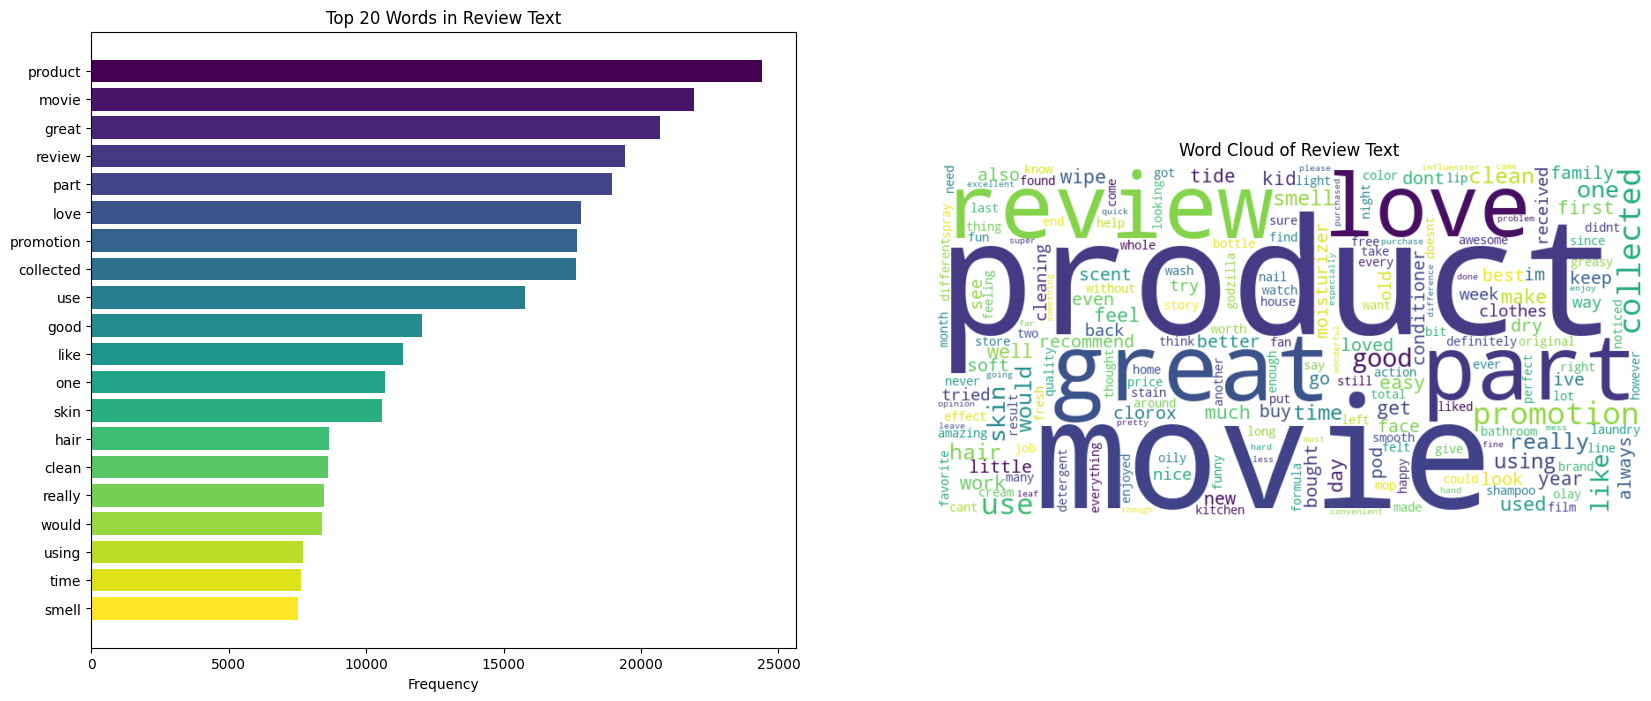

In [14]:
# Graficar palabras más comunes y nube de palabras para las reseñas de texto
plot_bars_and_wordcloud(common_terms_text, wordcloud_text, 'Top 20 Words in Review Text', 'Word Cloud of Review Text')

- El gráfico de barras muestra las 20 palabras más frecuentes en el texto de las reseñas. Destacan términos como `product`, `movie`, `great`, y `review`, lo cual es esperable considerando que muchos usuarios discuten específicamente sobre productos o películas en sus reseñas.
- La palabra `promotion` aparece en una frecuencia significativa, lo que podría sugerir que varias reseñas están relacionadas con productos que fueron parte de alguna promoción o se recibieron de manera gratuita para pruebas.
- Otros términos frecuentes, como `love`, `good`, y `like`, podrían indicar una tendencia general hacia comentarios positivos.

### Conteo de palabras

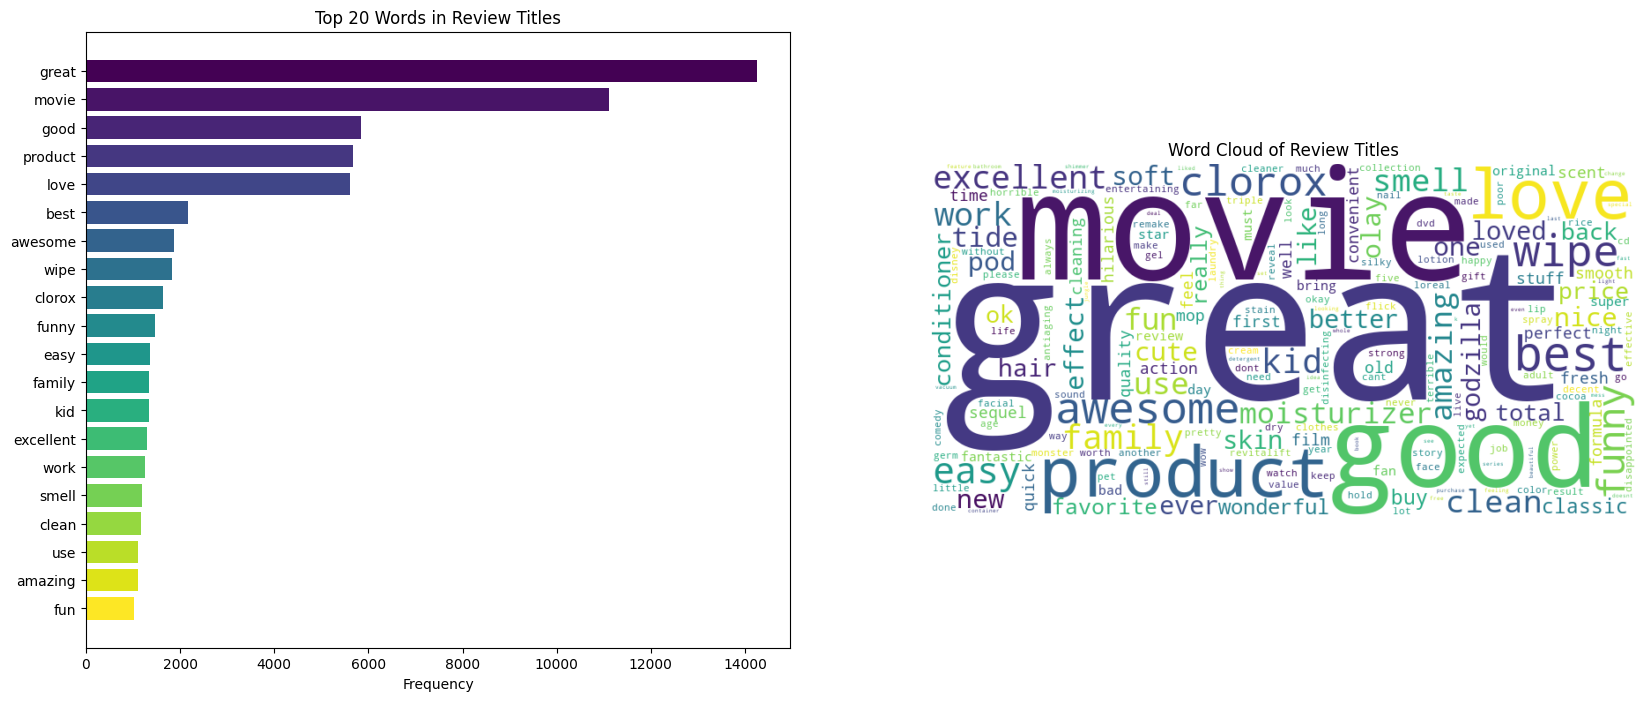

In [15]:
# Graficar palabras más comunes y nube de palabras para los títulos de las reseñas
plot_bars_and_wordcloud(common_terms_title, wordcloud_title, 'Top 20 Words in Review Titles', 'Word Cloud of Review Titles')

- Se puede observar que las palabras más comunes en los títulos de las reseñas son `great`, `movie`, y `good`, lo que refuerza la idea de que muchos usuarios están discutiendo productos de entretenimiento y calificándolos de manera positiva.
- Otros términos como `awesome`, `best`, y `fun` también sugieren una percepción generalmente favorable en los títulos, reflejando un entusiasmo por los productos mencionados.
- El término `wipe`, junto con la mención de marcas como `clorox`, indica la presencia de productos de limpieza entre las reseñas más comentadas.

### N-Grams

El análisis de palabras individuales proporciona una visión preliminar del contenido de las reseñas, permitiendo identificar los términos más frecuentes y obtener una idea general sobre los temas más mencionados. Sin embargo, este enfoque puede ser limitado, ya que no captura completamente el contexto en el que las palabras se utilizan.

Para profundizar en el análisis y obtener una mejor comprensión de los patrones y relaciones contextuales dentro de las reseñas, es recomendable implementar el análisis de bigramas (combinaciones de dos palabras) y trigramas (combinaciones de tres palabras). Estos n-gramas permiten captar relaciones entre palabras que podrían ser de mayor relevancia para el análisis.

In [16]:
def get_ngrams(texts, n=2, top_n=20):
    """
    Función para extraer n-gramas de un conjunto de textos.
    
    Args:
        texts (list): Lista de textos.
        n (int): Especifica si se van a generar bigramas (n=2) o trigramas (n=3).
        top_n (int): Número de n-gramas más comunes a devolver.

    Returns:
        List: Lista de los n-gramas más comunes y su frecuencia.
    """
    vectorizer = CountVectorizer(ngram_range=(n, n)).fit(texts)
    ngrams = vectorizer.transform(texts)
    sum_ngrams = ngrams.sum(axis=0)
    ngram_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    
    return ngram_freq[:top_n]

#### Bigramas

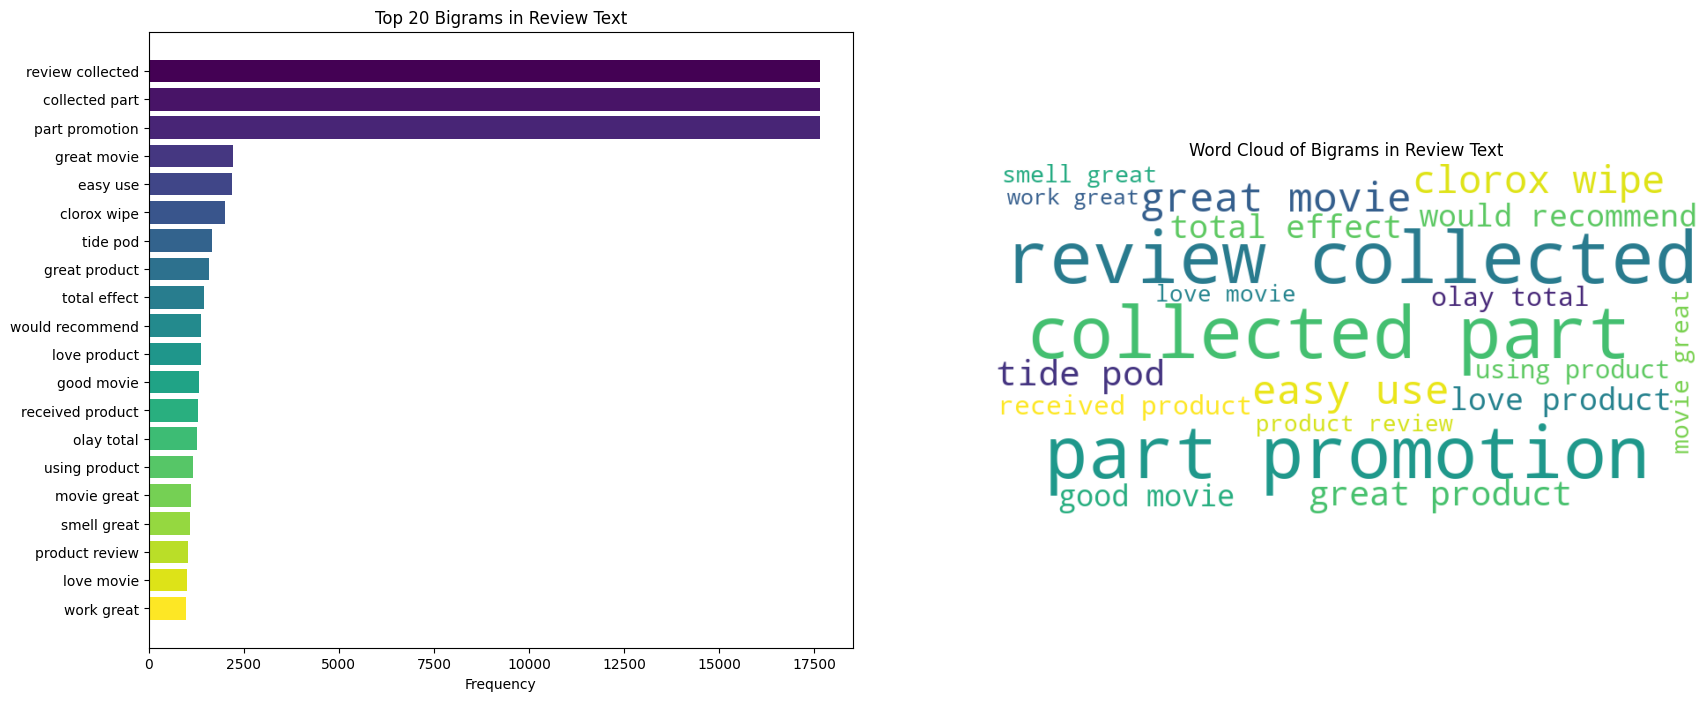

In [17]:
# Obtener los bigramas más comunes
bigram_freq = get_ngrams(reviews_df['clean_reviews_text'], n=2, top_n=20)

# Generar nube de palabras de bigramas
bigram_wordcloud = WordCloud(width=800, 
                             height=400, 
                             background_color='white').generate_from_frequencies(dict(bigram_freq))

# Graficar bigramas más comunes y nube de palabras
plot_bars_and_wordcloud(bigram_freq, 
                        bigram_wordcloud, 
                        'Top 20 Bigrams in Review Text', 
                        'Word Cloud of Bigrams in Review Text')

- `review collected` y `collected part`: Estos bigramas son los más frecuentes, lo que sugiere que muchos productos fueron reseñados como parte de promociones o campañas en las que los usuarios recibieron los productos gratis o como parte de un programa de prueba.
- `part promotion`: Refuerza la observación de que muchas reseñas mencionan promociones, lo que puede influir en el tono o la objetividad de las opiniones, ya que los productos fueron recibidos sin costo.
- `great movie` y `great product`: Estos bigramas indican una tendencia positiva hacia la experiencia con películas o productos, lo que sugiere que una porción significativa de las reseñas tiene una percepción favorable.
- `clorox wipe` y `tide pod`: Mencionan productos específicos, lo que puede indicar que las reseñas incluyen varias evaluaciones de productos de limpieza, ya que Clorox y Tide son marcas conocidas en este sector.
- `would recommend`: Este bigrama sugiere que muchos usuarios terminan sus reseñas con una recomendación positiva, indicando satisfacción con el producto.

#### Trigramas

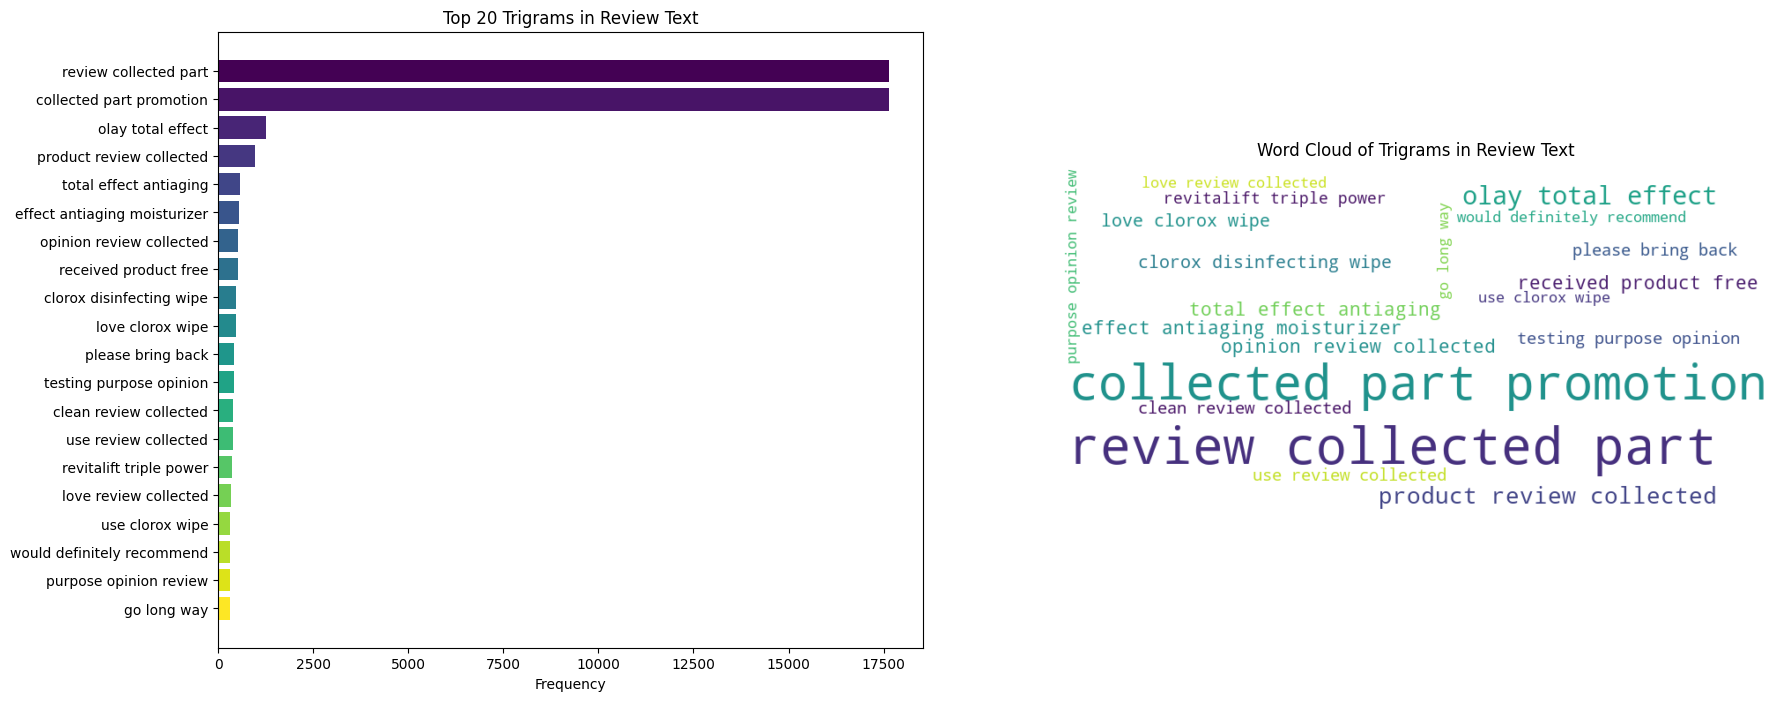

In [18]:
# Obtener los trigramas más comunes
trigram_freq = get_ngrams(reviews_df['clean_reviews_text'], n=3, top_n=20)
# Generar nube de palabras de trigramas
trigram_wordcloud = WordCloud(width=800, 
                              height=400, 
                              background_color='white').generate_from_frequencies(dict(trigram_freq))
# Graficar trigramas más comunes y nube de palabras
plot_bars_and_wordcloud(trigram_freq, 
                        trigram_wordcloud, 
                        'Top 20 Trigrams in Review Text', 
                        'Word Cloud of Trigrams in Review Text')

- `review collected part` y `collected part promotion`: Al igual que en los bigramas, estos trigramas también son altamente frecuentes, lo que refuerza la conclusión de que muchas reseñas fueron realizadas como parte de campañas promocionales.
- `olay total effect`: Un trigrama que muestra menciones a un producto específico de Olay, un indicio de que este producto es particularmente popular entre las reseñas.
- `total effect antiaging` y `effect antiaging moisturizer`: Estos trigramas indican que muchos usuarios están reseñando productos relacionados con el cuidado de la piel, especialmente aquellos con propiedades antienvejecimiento.
- `received product free`: Este trigrama refuerza la idea de que muchos productos se entregaron gratuitamente, como parte de promociones, lo que puede influir en la percepción positiva de las reseñas.
- `please bring back`: Este trigrama puede indicar que algunos productos reseñados ya no están disponibles o que han sido descontinuados, lo cual es relevante para identificar la demanda de ciertos artículos.

#### Hallazgos de los N-grams

El análisis de bigramas y trigramas revela que muchas de las reseñas están relacionadas con productos recibidos como parte de promociones. Además, se observa una tendencia hacia comentarios positivos, especialmente en categorías relacionadas con productos de cuidado personal y limpieza. Los bigramas y trigramas también destacan productos específicos que parecen ser populares entre los usuarios, como los de Clorox, Tide, y Olay.

## Análisis de Sentimientos

### Identificación de sentimientos

Para identificar las emociones presentes en las reseñas, se utilizará la herramienta **VADER** (Valence Aware Dictionary and sEntiment Reasoner), que emplea un diccionario predefinido de palabras positivas y negativas. **VADER** es particularmente adecuado para analizar sentimientos en texto breve y es capaz de capturar tanto el tono positivo como el negativo, además de proporcionar una medida de neutralidad.

El análisis de sentimientos se aplicará tanto al texto completo de la reseña como al título de la reseña, con el objetivo de asignar un nivel de positividad, neutralidad, o negatividad a cada reseña. 

Para cada reseña, se calcularán las siguientes métricas:

- `Positividad`: Indica el grado de positividad en el texto.
- `Negatividad`: Refleja el grado de negatividad presente en la reseña.
- `Neutralidad`: Representa la proporción de contenido que no expresa emociones fuertes ni positivas ni negativas.
- `Puntuación compuesta` (compound): Es una métrica que combina las otras tres puntuaciones y refleja el sentimiento general del texto, en una escala de -1 (muy negativo) a 1 (muy positivo).

In [19]:
# Descargar el lexicon de VADER
nltk.download('vader_lexicon')

# Inicializar el analizador de sentimientos de VADER
sia = SentimentIntensityAnalyzer()

# Aplicar análisis de sentimientos tanto al texto de la reseña como al título
reviews_df['sentiment_text'] = reviews_df['clean_reviews_text'].apply(lambda x: sia.polarity_scores(x))
reviews_df['sentiment_title'] = reviews_df['clean_reviews_title'].apply(lambda x: sia.polarity_scores(x))

# Extraer puntajes de positividad, negatividad, neutralidad y compound para el texto de la reseña
reviews_df['negativity_text'] = reviews_df['sentiment_text'].apply(lambda x: x['neg'])
reviews_df['positivity_text'] = reviews_df['sentiment_text'].apply(lambda x: x['pos'])
reviews_df['neutrality_text'] = reviews_df['sentiment_text'].apply(lambda x: x['neu'])
reviews_df['compound_text'] = reviews_df['sentiment_text'].apply(lambda x: x['compound'])

# Extraer puntajes de positividad, negatividad, neutralidad y compound para el título de la reseña
reviews_df['negativity_title'] = reviews_df['sentiment_title'].apply(lambda x: x['neg'])
reviews_df['positivity_title'] = reviews_df['sentiment_title'].apply(lambda x: x['pos'])
reviews_df['neutrality_title'] = reviews_df['sentiment_title'].apply(lambda x: x['neu'])
reviews_df['compound_title'] = reviews_df['sentiment_title'].apply(lambda x: x['compound'])

# Mostrar los primeros resultados del análisis de sentimientos
reviews_df[['clean_reviews_text', 'negativity_text', 'positivity_text', 'neutrality_text', 'compound_text', 
            'clean_reviews_title', 'negativity_title', 'positivity_title', 'neutrality_title', 'compound_title']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,clean_reviews_text,negativity_text,positivity_text,neutrality_text,compound_text,clean_reviews_title,negativity_title,positivity_title,neutrality_title,compound_title
0,love album good hip hop side current pop sound...,0.094,0.278,0.627,0.6908,awesome,0.0,1.0,0.0,0.6249
1,good flavor review collected part promotion,0.000,0.367,0.633,0.4404,good,0.0,1.0,0.0,0.4404
2,good flavor,0.000,0.744,0.256,0.4404,good,0.0,1.0,0.0,0.4404
3,read review looking buying one couple lubrican...,0.196,0.089,0.715,-0.7305,disappointed,1.0,0.0,0.0,-0.4767
4,husband bought gel u gel caused irritation fel...,0.302,0.140,0.558,-0.4423,irritation,1.0,0.0,0.0,-0.5106


El análisis de sentimientos realizado con VADER permitió desglosar las emociones presentes tanto en el texto de las reseñas como en sus títulos. Para cada reseña, se calcularon métricas de **negatividad**, **positividad**, **neutralidad** y una puntuación **compuesta** que refleja el sentimiento global en una escala de -1 a 1. Estas métricas ofrecen una visión clara del tono general de cada reseña.

- `clean_reviews_text`: Contiene el texto de la reseña preprocesado, listo para el análisis.

- `negativity_text`, `positivity_text`, y `neutrality_text`: Miden los grados de sentimiento negativo, positivo y neutral, respectivamente, en el texto de la reseña.

- `compound_text`: Resume el sentimiento global de la reseña, combinando las métricas anteriores en una única puntuación.

El mismo análisis se aplicó a los títulos de las reseñas, reflejando el sentimiento en las columnas correspondientes. En general, se observó una fuerte correlación entre el sentimiento del texto y el título, lo que indica que los títulos capturan bien el tono general de la reseña.

### Hallazgos 

Para medir el sentimiento de las reseñas se utilizara la variable `compound_text`. Esto ya que como se menciono anteriormente compound da una visión mas general de la positividad, negatividad o neutralidad del texto en un ranto de -1 a 1. Siendo los valores mas cercanos a 1 los mas positivos y los mas cercanos a -1 los mas negativos, con los mas cercanos a 0 siendo los mas neutrales

In [20]:
# Agrupar por producto (por 'name') y calcular la media de la puntuación compuesta
product_sentiment = reviews_df.groupby('name')['compound_text'].mean().reset_index()

#### Top 10 Productos de mejor calidad dado su reseña

In [21]:
# Ordenar los productos por la puntuación compuesta
top_10_best_products = product_sentiment.sort_values(by='compound_text', ascending=False).head(10)
# Mostrar los 10 mejores productos según la puntuación compuesta
print("Los 10 mejores productos según la puntuación compuesta:")
display(top_10_best_products)

Los 10 mejores productos según la puntuación compuesta:


,name,compound_text
40,Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide...,0.98820
198,JNH Lifestyles Goldstar 3 Person FAR Infrared ...,0.98450
86,Carson-Dellosa Publishing Photographic Learnin...,0.98320
48,Bebe Au Lait174 Premium Muslin Nursing Scarf -...,0.97900
144,Elvis Presley - Girl Happy (cd),0.97290
160,"Haagen-Dazs Gelato, Sea Salt Caramel",0.96180
146,Essex Pendulum Wall Clock Black - Timekeeper174,0.96180
481,"The Honest Company Bar Soap, Lavender",0.96115
530,Who Is Harry Nilsson (and Why Is Ever (dvd),0.95780
204,John Frieda Brilliant Brunette Colour Protecti...,0.95720


#### Top los 10 Productos de menor calidad dado su reseña

In [22]:
# Ordenar los productos por la puntuación compuesta
top_10_worst_products = product_sentiment.sort_values(by='compound_text', ascending=True).head(10)
# Mostrar los 10 peores productos según la puntuación compuesta
print("Los 10 peores productos según la puntuación compuesta:")
display(top_10_worst_products)

Los 10 peores productos según la puntuación compuesta:


,name,compound_text
377,Pocket Watch Wall Clock Distressed Black - Yos...,-0.7783
169,"Heinz Tomato Ketchup, 38oz",-0.7003
181,Horizon174 Organic Unsalted Butter - 1lbs,-0.6486
471,Swann Door Alarm - White (swads-Alarmk-Gl),-0.5336
521,"Wallmount Server Cabinet (450mm, 9 RU)",-0.4939
131,Dauphine Traditional French Accent Coffee Tabl...,-0.4404
142,Ecotrin Pain Reliever Regular Strength 325mg T...,-0.4019
62,"Black Opal Total Coverage Spot & Scar Eraser, ...",-0.3612
174,High-Dome Floor Door Stop,-0.3182
357,Peak Long Life Antifreeze Coolant 1-Gal.,-0.3089


#### Top 10 Usuarios que dan la mayor cantidad de reseñas a distintos productos

In [23]:
# Agrupar por usuario y contar el número de reseñas
user_reviews_count = reviews_df['reviews.username'].value_counts().head(10).reset_index()
# Renombrar las columnas 
user_reviews_count.columns = ['username', 'review_count']
# Mostrar los 10 usuarios con más reseñas
display(user_reviews_count)

,username,review_count
0,An anonymous customer,419
1,Anonymous,113
2,Mike,105
3,Chris,86
4,ByAmazon Customer,58
5,Dave,57
6,John,49
7,Rick,41
8,James,32
9,Robert,30


#### Top 10 Usuarios que más reseñas negativas y positivas dan en promedio

In [24]:
# Calcular la puntuación compuesta promedio por usuario
user_sentiment = reviews_df.groupby('reviews.username')['compound_text'].mean().reset_index()

# Usuarios con más reseñas positivas
top_10_positive_users = user_sentiment.sort_values(by='compound_text', ascending=False).head(10)
print("Usuarios con más reseñas positivas:")
display(top_10_positive_users)

# Usuarios con más reseñas negativas
top_10_negative_users = user_sentiment.sort_values(by='compound_text', ascending=True).head(10)
print("Usuarios con más reseñas negativas:")
display(top_10_negative_users)

Usuarios con más reseñas positivas:


,reviews.username,compound_text
23806,Marty Gillis,0.9989
47706,kidsfirstmedia,0.9982
37871,WLangston,0.9979
31195,RooBoo,0.9979
38342,Wlangston,0.9979
11024,DoubleJ,0.9979
44759,giargiarz,0.9977
52599,pumpkinface,0.9973
27974,Nyrall,0.9972
31805,Sable601,0.9972


Usuarios con más reseñas negativas:


,reviews.username,compound_text
35271,TVCritic,-0.9831
47214,kaeebaaby,-0.9674
12532,Filmcritic86,-0.9628
31265,Roseville Mopper,-0.9561
53333,roseville mopper,-0.9561
882,About2bMom,-0.9509
37410,UsuallyHappyCustomer,-0.9502
27604,Nikkie,-0.9468
52537,princessnaomi,-0.9451
28330,Ovonel,-0.9451


#### Top 10 Productores que tienen productos de mejor calidad

In [25]:
# Calcular la puntuación compuesta promedio por fabricante
producer_sentiment = reviews_df.groupby('manufacturer')['compound_text'].mean().reset_index()
# Ordenar los fabricantes por la puntuación compuesta
top_10_best_producers = producer_sentiment.sort_values(by='compound_text', ascending=False).head(10)
# Mostrar los 10 mejores fabricantes según la puntuación compuesta
display(top_10_best_producers)

,manufacturer,compound_text
30,Avery,0.9882
152,JNH Lifestyles,0.9845
66,Carson-Dellosa Publishing,0.9832
40,Bebe au Lait,0.9790
300,SBME SPECIAL MKTS.,0.9729
365,Timekeeper,0.9618
99,Dreyer's Grand Ice Cream/Nestle Ice Cream Company,0.9618
168,KINO,0.9578
159,John Frieda,0.9572
35,Baby Jogger,0.9428


#### Top 10 Productores que tienen productos de peor calidad

In [26]:
# Ordenar los fabricantes por la puntuación compuesta
top_10_worst_producers = producer_sentiment.sort_values(by='compound_text', ascending=True).head(10)
# Mostrar los 10 peores fabricantes según la puntuación compuesta
display(top_10_worst_producers)

,manufacturer,compound_text
413,Yosemite Home Decor,-0.7783
127,Heinz North America,-0.7003
135,Horizon Organic,-0.6486
352,Swann Communications USA,-0.5336
415,iStarUSA,-0.4939
402,Wholesale Interiors,-0.4404
104,Ecotrin,-0.4019
44,Biocosmetic Research Labs,-0.3612
337,Stanley Hardware,-0.3182
270,Peak,-0.3089
